In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

# Load mono scan

In [4]:
fc = FileChooser('/sf/alvra/data/p18741/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18741/raw/scan_info', filename='', show_hidden='False')

### Next compare PIPS diode with JF in TFY

In [ ]:
quantile_band = 0.5
pid_roll = 0

channel_list = [channel_PIPS_trans, channel_Izero122, channel_PIPS_waveform, 'JF04T01V01']

threshold_low = 5.5
threshold_high = 10

####################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

PIPS = []
Izero117 = []
Izero122 = []
NormPSSS = []
Spectrum_PSSS = []
PSSS_eV =[]


In [5]:
quantile_band = 0.5
pid_roll = 0

channel_list = [channel_PIPS_trans, channel_Izero122, channel_PIPS_waveform, 'JF04T01V01']

threshold_low = 5.5
threshold_high = 10
####################################################################################################3

json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

XAS_JF = []
XAS_pips = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    #print (filename)
    exists = os.path.isfile(filename)
    if exists: # and i !=21:
        clear_output(wait=True)
        print("step", i+1, "of",numFiles, f": Processing {filename}")
        
        filenames = filename.replace('BSREAD', '*')
        results = load_data_compact(channel_list, filenames)
        
        data_trans_shot = -results[channel_PIPS_trans]
        data_JF = results['JF04T01V01']
        IzeroFEL_shot = results[channel_Izero122]
        
        waveform = results[channel_PIPS_waveform]
        
        nframes = data_JF.shape[0]
        print (nframes)
        data_JF_thr = np.copy(data_JF)
        
        for j in range(nframes):
            image = data_JF[j,:]
            image_thr = image.copy()
            image_thr[image < threshold_low] = 0
            image_thr[image > threshold_high] = 0
            data_JF_thr[j,:] = image_thr[:]
        
        XASpips_shot_norm = data_trans_shot / IzeroFEL_shot
        XASJF_shot_norm = np.roll(data_JF_thr.sum(axis = 1).sum(axis = 1), pid_roll, axis = 0) / IzeroFEL_shot
        
        df_data_pips = pd.DataFrame(XASpips_shot_norm)
        XAS_pips.append(np.nanquantile(df_data_pips, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        
        df_data_JF = pd.DataFrame(XASJF_shot_norm)
        XAS_JF.append(np.nanquantile(df_data_JF, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        
        Energy_eV.append(data['scan_readbacks'][i][0]) ## Energy from the json file

XAS_JF = np.asarray(XAS_JF)
XAS_pips = np.asarray(XAS_pips)
Energy_eV = np.asarray(Energy_eV)
        
        
print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

step 60 of 60 : Processing /sf/alvra/data/p18741/raw/Co_YIG_monoscan_005/run_000651.BSREAD.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000587.JF04T01V01.res.h5
jungfrau file: 16:49 08.12.2020
pedestal file: 16:22 08.12.2020
    mtime difference: 0:26:02.957215
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF09T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000587.JF09T01V01.res.h5
jungfrau file: 16:49 08.12.2020
pedestal file: 16:23 08.12.2020
    mtime difference: 0:26:00.838744
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF10T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000587.JF10T01V01.res.h5
jungfrau file: 16:49 08.12.2020
pedestal file: 16:23 08.12.2020
    mtime difference: 0:25:55.009381

-----------------------------------------------------------------------------

<IPython.core.display.Javascript object>


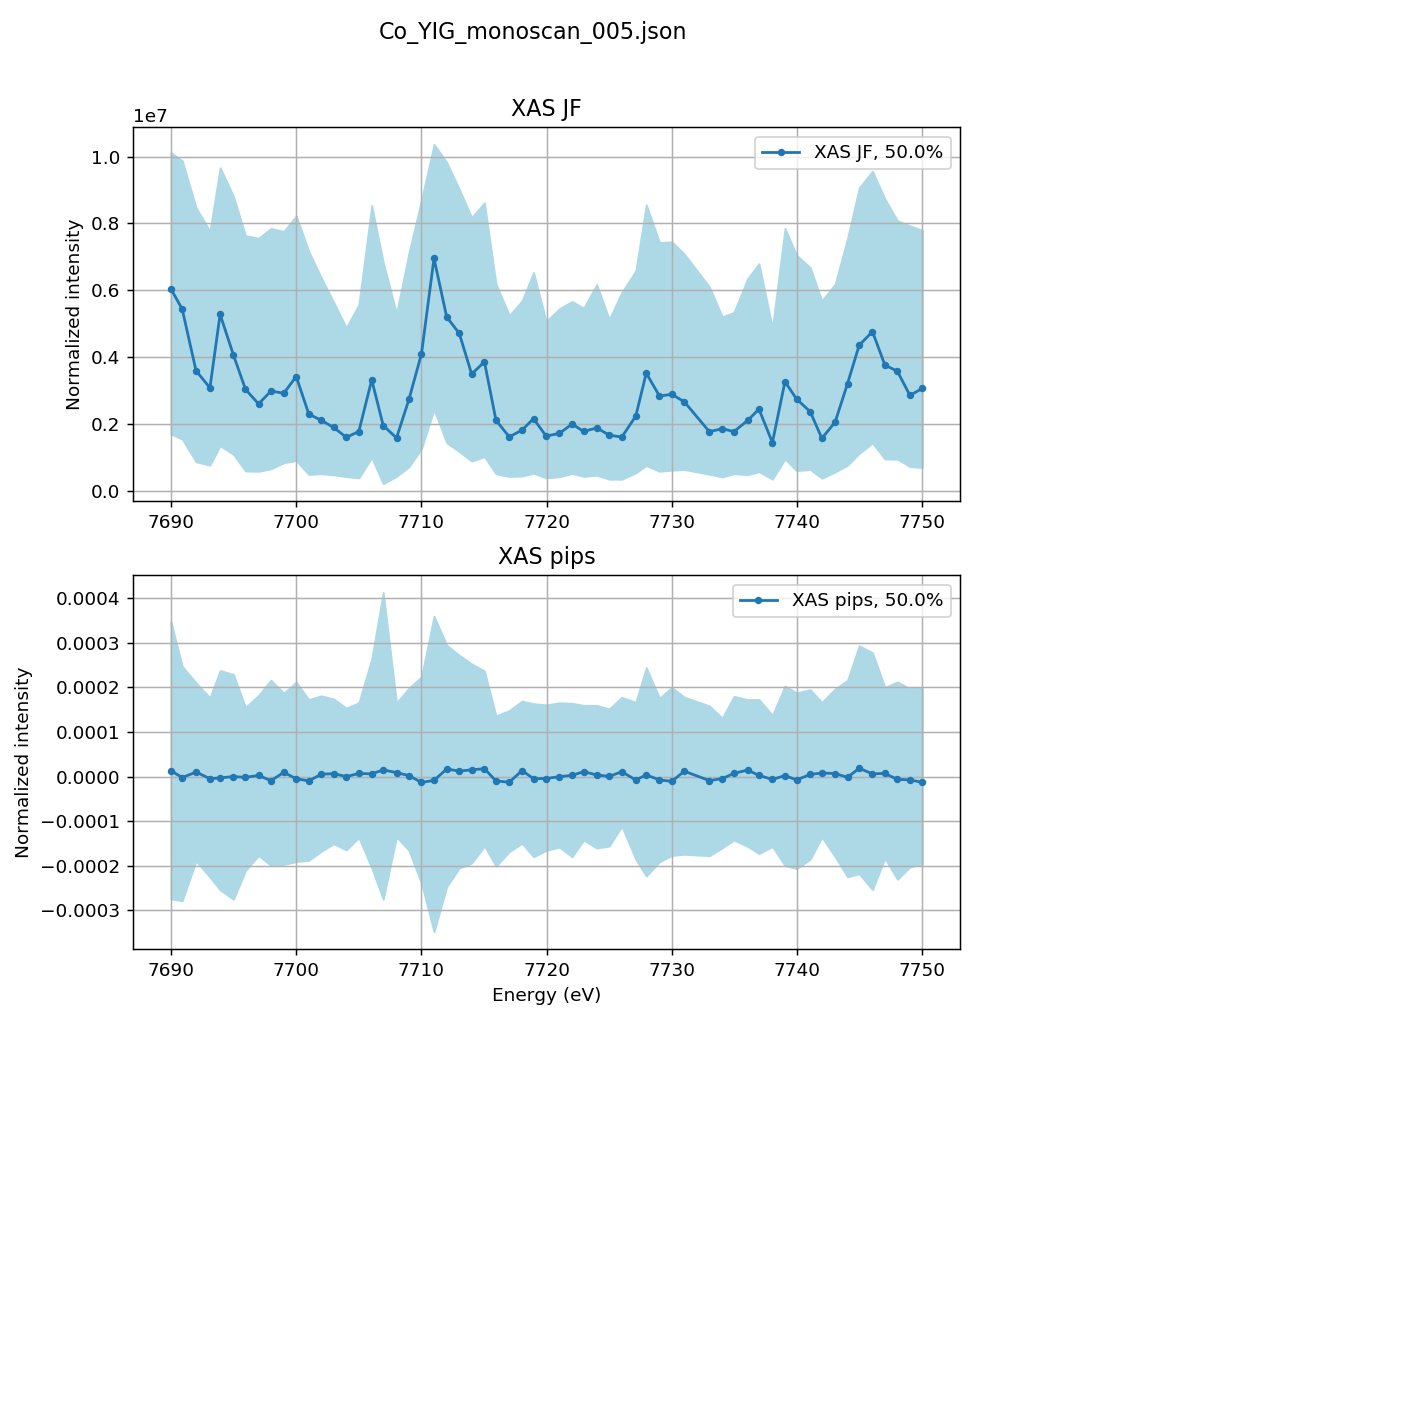

In [6]:
plt.figure(figsize = (8,8))
plt.suptitle (fc.selected_filename)

XAS1 = XAS_JF[:,0]
err_low1 = XAS_JF[:,1]
err_high1 = XAS_JF[:,2]

XAS2 = XAS_pips[:,0]
err_low2 = XAS_pips[:,1]
err_high2 = XAS_pips[:,2]

plt.subplot(211)
plt.plot(Energy_eV, XAS1, label='XAS JF, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low1, err_high1, color='lightblue')

plt.title("XAS JF")
plt.ylabel('Normalized intensity')
#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
plt.plot(Energy_eV, XAS2, label='XAS pips, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low2, err_high2, color='lightblue')

plt.title("XAS pips")
plt.ylabel('Normalized intensity')
plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.grid()

plt.show()

### First, without any filtering of the data, check data distributions with quantiles 

In [17]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list = [channel_PIPS_trans, channel_Izero122, channel_energy]

######################################################
from sfdata import SFScanInfo

json_file = fc.selected
print (json_file)

scan = SFScanInfo(fc.selected)



with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    fn = str(data['scan_files'][i][0])    
    exists = os.path.isfile(fn)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        results = load_data_compact(channel_list, fn)

        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(fn, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = results[channel_PIPS_fluo]
        print ("Loaded {} shots".format(len(DataFluo_shot)))
    
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
              
        DataFluo.append(np.nanquantile(df_fluo, quantiles))        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 1 of 161 : Processing /sf/alvra/data/p18741/raw/Co_YIG_monoscan_008/run_000890.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           5000 / 5000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET          5000 / 5000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         5000 / 5000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 5000 / 5000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 5000 / 5000 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


KeyError: 'SARES11-GES1:CH2_VAL_GET'

In [33]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

######################################################

json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    fn = str(data['scan_files'][i][0])    
    exists = os.path.isfile(fn)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        results = load_data_compact(channel_list, fn)

        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(fn, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = results[channel_PIPS_fluo]
        print ("Loaded {} shots".format(len(DataFluo_shot)))
    
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
              
        DataFluo.append(np.nanquantile(df_fluo, quantiles))        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 31 of 31 : Processing /sf/alvra/data/p18741/raw/scan_data/Na2SO4_monoscan_1/run_002140.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Loaded 500 shots
Job done!


<IPython.core.display.Javascript object>


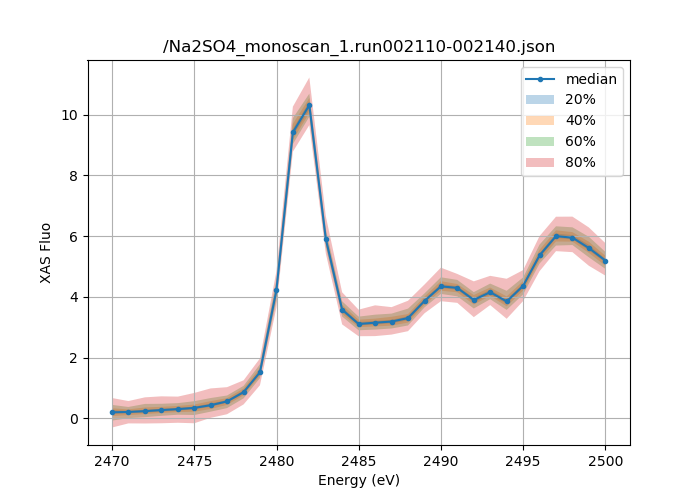

In [34]:
plt.figure(figsize = (7,5))

plt.plot(Energy_eV, DataFluo[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo[:,4]),np.array(DataFluo[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,3]),np.array(DataFluo[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,2]),np.array(DataFluo[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,1]),np.array(DataFluo[:,8]), label='80%', alpha = 0.3)
plt.grid()

plt.legend(loc="best")
plt.ylabel("XAS Fluo")
plt.xlabel("Energy (eV)")
plt.title(json_file.split('scan_info')[1], fontsize=12)

plt.show()

### Now choose thresholds and quantile

In [35]:
min_I0 = 0
min_fluo = 0
quantile_corr = 0.5

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

########################################################################
json_file = fc.selected
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo = []
Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        results = load_data_compact(channel_list, filename)
        
        #(DataTrans_shot, DataFluo_shot, IzeroFEL_shot, Laser, Energy_shot, PulseIDs) = load_FEL_scans(filename, channel_energy)
        
        Energy_shot   = results[channel_energy]
        IzeroFEL_shot = results[channel_Izero122]
        DataFluo_shot = results[channel_PIPS_fluo]
        
        print ("Loaded {} shots".format(len(DataFluo_shot)))
        
        threshold_FEL = IzeroFEL_shot > min_I0
        threshold_fluo = DataFluo_shot > min_fluo
        thresholds_filter = threshold_FEL & threshold_fluo
        DataFluo_shot = DataFluo_shot[thresholds_filter]
        IzeroFEL_shot = IzeroFEL_shot[thresholds_filter]
        
        print ("survived {} shots".format(len(DataFluo_shot)))
        
        DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
        
        med = np.median(DataFluo_shot_norm)
        qnt_low = np.nanquantile(DataFluo_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_shot_norm, 0.5 + quantile_corr/2)
        condition_corr_low = DataFluo_shot_norm > qnt_low
        condition_corr_high = DataFluo_shot_norm < qnt_high
        correlation_filter = condition_corr_low & condition_corr_high 
        DataFluo_shot_norm = DataFluo_shot_norm[correlation_filter]
        
        print ("survived {} shots".format(len(DataFluo_shot_norm)))
        
        df_fluo = pd.DataFrame(DataFluo_shot_norm)
        DataFluo.append(np.nanquantile(df_fluo, [0.5, 0, 1]))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo = np.asarray(DataFluo)                  
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")

step 31 of 31 : Processing /sf/alvra/data/p18741/raw/scan_data/Na2SO4_monoscan_1/run_002140.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Loaded 500 shots
survived 497 shots
survived 247 shots
Job done!


<IPython.core.display.Javascript object>


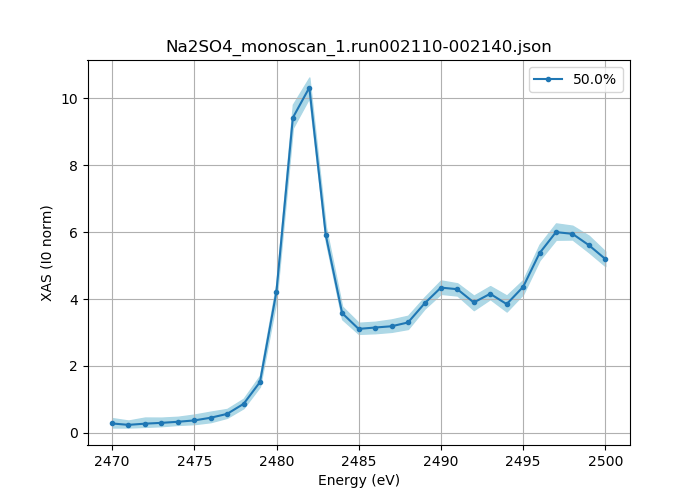

In [36]:
plt.figure(figsize = (7,5))

XAS = DataFluo[:,0]
err_low = DataFluo[:,1]
err_high = DataFluo[:,2]

plt.plot(Energy_eV, XAS, label='{}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')
plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.title(fc.selected_filename, fontsize=12)
plt.grid()

plt.show()